In [15]:
import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torchvision
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# Source: https://www.geeksforgeeks.org/machine-learning/implementation-of-a-cnn-based-image-classifier-using-pytorch/

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 90),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

normalize_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [17]:
test_path = './catdog_data/test'
train_path = './catdog_data/train'
validation_path = './catdog_data/validation'

train_data = ImageFolder(root = train_path, transform = train_transform)
test_data = ImageFolder(root = test_path, transform = normalize_transform)
validation_data = ImageFolder(root = validation_path, transform = normalize_transform)

In [18]:
batch_size = 64

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

validation_dataloader = DataLoader(
    dataset = validation_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

print('Number of training batches: ', len(train_dataloader))
print('Number of validation batches: ', len(validation_dataloader))
print('Number of testing batches: ', len(test_dataloader))

Number of training batches:  32
Number of validation batches:  10
Number of testing batches:  7


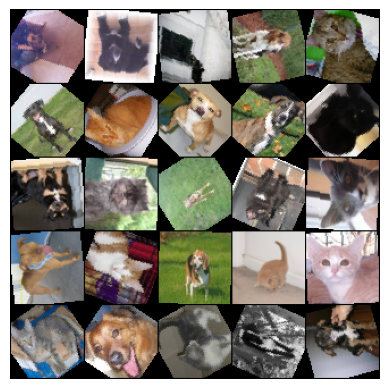

In [19]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [ ]:
class CNN(nn.Module):

    def __init__(self, activation_function):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = 3, padding = 1)
        self.act1 = activation_function
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding = 1)
        self.act2 = activation_function
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 2, kernel_size = 3, padding = 1)
        self.act3 = activation_function
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)
        self.act5 = activation_function
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.maxpool1(x)
        x = self.act2(self.conv2(x))
        x = self.maxpool2(x)
        x = self.act3(self.conv3(x))
        x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.act5(self.fc1(x))
        x = self.fc2(x)
        return x


In [22]:
class CNN(nn.Module):
    def __init__(self, activation_function):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            activation_function,
            nn.MaxPool2d(kernel_size = 2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.MaxPool2d(kernel_size = 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 2, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(2),
            activation_function,
            nn.MaxPool2d(kernel_size = 2)
        )

        self.fc1 = nn.Linear(2 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)
        self.act = activation_function
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.act(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
model = CNN(nn.SiLU())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in validation_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader):.4f}, Validation Accuracy: {accuracy:.2f}%")
    train_losses.append(running_loss/len(train_dataloader))
    val_losses.append(accuracy)

# Save model achieving >95%
torch.save(model.state_dict(), "catsanddogs_cnn.pth")

Epoch 1/30, Loss: 0.6808, Validation Accuracy: 52.33%
Epoch 2/30, Loss: 0.6462, Validation Accuracy: 61.67%
Epoch 3/30, Loss: 0.6346, Validation Accuracy: 62.50%
Epoch 4/30, Loss: 0.6200, Validation Accuracy: 61.67%
Epoch 5/30, Loss: 0.6129, Validation Accuracy: 61.83%
Epoch 6/30, Loss: 0.6040, Validation Accuracy: 65.00%
Epoch 7/30, Loss: 0.6028, Validation Accuracy: 64.50%
Epoch 8/30, Loss: 0.5947, Validation Accuracy: 64.33%
Epoch 9/30, Loss: 0.5868, Validation Accuracy: 65.00%
Epoch 10/30, Loss: 0.5941, Validation Accuracy: 65.00%
Epoch 11/30, Loss: 0.5819, Validation Accuracy: 64.33%
Epoch 12/30, Loss: 0.5791, Validation Accuracy: 66.67%
Epoch 13/30, Loss: 0.5664, Validation Accuracy: 63.83%
Epoch 14/30, Loss: 0.5720, Validation Accuracy: 65.33%
Epoch 15/30, Loss: 0.5641, Validation Accuracy: 67.17%
Epoch 16/30, Loss: 0.5625, Validation Accuracy: 66.00%
Epoch 17/30, Loss: 0.5685, Validation Accuracy: 64.83%
Epoch 18/30, Loss: 0.5577, Validation Accuracy: 66.83%
Epoch 19/30, Loss: 

3 conv lag, old model:

Epoch 1/10, Loss: 0.6943, Validation Accuracy: 57.33%
Epoch 2/10, Loss: 0.6894, Validation Accuracy: 57.67%
Epoch 3/10, Loss: 0.6715, Validation Accuracy: 60.33%
Epoch 4/10, Loss: 0.6773, Validation Accuracy: 56.83%
Epoch 5/10, Loss: 0.6621, Validation Accuracy: 59.17%
Epoch 6/10, Loss: 0.6500, Validation Accuracy: 62.67%
Epoch 7/10, Loss: 0.6388, Validation Accuracy: 63.00%
Epoch 8/10, Loss: 0.6376, Validation Accuracy: 62.00%
Epoch 9/10, Loss: 0.6303, Validation Accuracy: 61.33%
Epoch 10/10, Loss: 0.6485, Validation Accuracy: 65.67%

NameError: name 'val_losses' is not defined

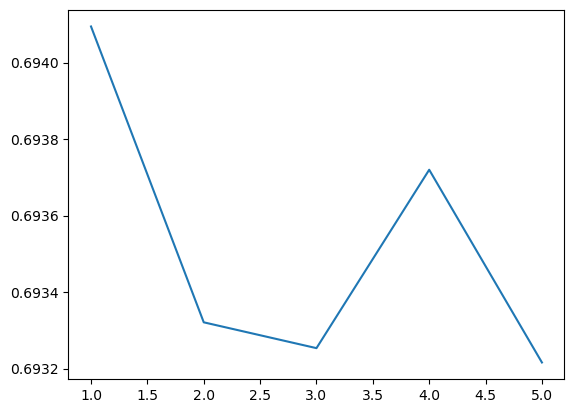

In [ ]:
plt.plot(range(1, epochs + 1), train_losses)
plt.plot(range(1, epochs + 1), val_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Training and validation loss")
plt.show()